In [451]:
import numpy as np
import matplotlib.pyplot as plt

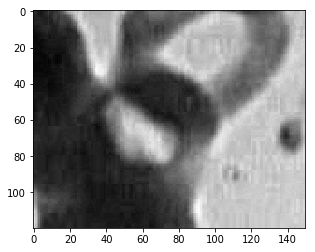

In [452]:
from PIL import Image, ImageDraw
import requests

url = 'https://www.worldgbc.org/sites/default/files/Content%20pages%20old%20europe%20buildings.jpg'
path = "./BloodImage_00004.jpg"

img = Image.open(path).convert('L')
X0 = np.array(img).astype(np.float64)[:120, :150] / 255

plt.imshow(X0, cmap='gray')

In [455]:
print("S1-norm is", np.linalg.norm(X0, ord="nuc"), ", trace is", np.trace(X0))

alpha = np.trace(X0)

S1-norm is 110.89197609470779 , trace is 82.56862745098042


In [456]:
def f(x, b):
    return np.norm(x - b) ** 2

def grad_f(x):
    b = X0.reshape(-1)
    return 2 * (x - b) 

In [457]:
def A(X):
    return X.reshape(-1)

def A_star(x):
    return x.reshape(X0.shape)

In [458]:
from scipy.sparse import linalg as slin
from tqdm import tqdm

class Sketch:
    def __init__(self):
        self.Omega = None
        self.Psi = None
        self.Y = None
        self.W = None
        self.shape = None
        self.r = 0
    
    def init(self, r):
        self.r = r
        
        m, n = X0.shape
        self.shape = X0.shape
        
        k = 2 * r + 1
        l = 4 * r + 3
        
        self.Omega = np.random.randn(n, k)
        self.Psi = np.random.randn(l, m)
        
        self.Y = np.zeros((m, k))
        self.W = np.zeros((l, n))
        
    def CGMU_update(self, u, v, nu):
        self.Y = (1 - nu) * self.Y + nu * u @ (v.conj().T @ self.Omega)
        self.W = (1 - nu) * self.W + nu * (self.Psi @ u) @ v.conj().T
        
    def reconstruct(self):
        Q, _ = np.linalg.qr(self.Y)
        B = np.linalg.pinv(self.Psi @ Q) @ self.W
        
        U, S, V = np.linalg.svd(B, full_matrices=False)
                
        return Q @ U[:,:self.r] @ np.diag(S[:self.r]) @ V[:self.r,:]
    
    def factorize(self, num_iter=50, alpha = 1.0, eps=1e-10):
        z = np.ones(self.shape).reshape(-1)
        
        for i in tqdm(range(num_iter)):
            u, _, v = np.linalg.svd(A_star(grad_f(z)))
            u = u[:,:1]
            v = v[:1,:].conj().T
            
            h = A((-alpha * u @ v.T))
            e = (z - h) @ grad_f(z)
            
            err.append(np.abs(e))
            if np.abs(e) <= eps :
                break
            
            nu = 2 / (i + 2)
            z = (1 - nu) * z + nu * h
            self.CGMU_update(-alpha * u, v, nu)

In [459]:
err = []
sketch = Sketch()
sketch.init(400)
sketch.factorize(alpha=alpha, num_iter=10)
X_rec = sketch.reconstruct()


100%|██████████| 10/10 [00:00<00:00, 103.33it/s]

6


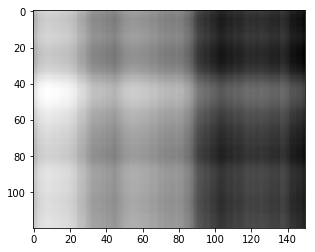

In [460]:
# X_rec = U @ np.diag(S) @ V

print(np.linalg.matrix_rank(X_rec))

plt.imshow(-1 * X_rec, cmap='gray')

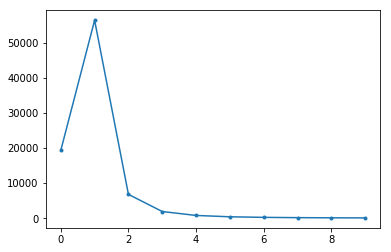

In [461]:
plt.plot(err, '.-')

In [462]:
import cvxpy as cvx

In [463]:
X = cvx.Variable(X0.shape)
b = A(X0)

def conv_f(X):
    return cvx.norm(cvx.vec(X) - b) ** 2

objective = cvx.Minimize(conv_f(X))

constraints = [
    cvx.norm(X, "nuc") <= alpha
]

p = cvx.Problem(objective, constraints)
p.solve(verbose=True)

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 90859, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 54587, constraints m = 72590
Cones:	primal zero / dual free vars: 18000
	linear vars: 1
	soc vars: 18004, soc blks: 2
	sd vars: 36585, sd blks: 1
Setup time: 4.93e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.59e+21  2.02e+21  1.00e+00 -1.94e+23  5.23e+22  2.09e+22  1.24e-01 
   100| 1.06e-02  4.74e-03  9.03e-02  3.58e+00  4.39e+00  8.15e-01  7.29e+

138.67960987155348

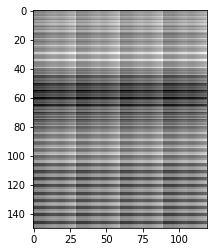

In [464]:
plt.imshow(X.value.real.T, cmap='gray')

In [465]:
np.linalg.matrix_rank(X.value.real.T)

120

In [466]:
X.value.real.T

array([[0.61203995, 0.6133061 , 0.61369082, ..., 0.63026805, 0.63295677,
        0.6368719 ],
       [0.61210499, 0.61337197, 0.61375816, ..., 0.63033993, 0.63302797,
        0.6369423 ],
       [0.61999808, 0.62128062, 0.6216708 , ..., 0.63847084, 0.64119479,
        0.64516119],
       ...,
       [0.61116729, 0.61243158, 0.61281642, ..., 0.62937392, 0.63205872,
        0.63596848],
       [0.6165152 , 0.61779114, 0.61817964, ..., 0.6348803 , 0.63758748,
        0.64153034],
       [0.61056714, 0.61183059, 0.61221494, ..., 0.62875301, 0.63143522,
        0.63534104]])

In [467]:
X_rec * -1

array([[-0.54433742, -0.54011391, -0.53426843, ..., -0.66513937,
        -0.66784839, -0.67294466],
       [-0.5471216 , -0.54287766, -0.53700393, ..., -0.66850784,
        -0.67122998, -0.67635092],
       [-0.54911426, -0.54485547, -0.53896119, ..., -0.67092554,
        -0.67365723, -0.67879612],
       ...,
       [-0.53454715, -0.53038454, -0.52462329, ..., -0.65360253,
        -0.65627212, -0.66129449],
       [-0.53431862, -0.53015761, -0.52439857, ..., -0.65332837,
        -0.65599693, -0.66101738],
       [-0.5342655 , -0.53010484, -0.52434629, ..., -0.65326513,
        -0.65593347, -0.66095348]])

In [468]:
X_diff = X.value.real - np.sign(X_rec) * X_rec

In [469]:
np.mean(X_diff) / np.mean(X.value.real.T)

0.038673113421996884

In [470]:
np.mean(X_diff) / np.mean(X_rec)

0.04022888984168539

In [365]:
import os

root_dir = "./Bootstrap/"

paths = sorted(os.listdir(root_dir))
paths_nr = len(paths)

F = np.empty((19200, paths_nr))

for j, path in tqdm(enumerate(paths)):
    img = Image.open(root_dir + path).convert('L')
    F[:, j] = np.array(img).astype(np.float64).flatten()


0it [00:00, ?it/s]
79it [00:00, 784.77it/s]
223it [00:00, 908.33it/s]
364it [00:00, 1015.80it/s]
509it [00:00, 1115.71it/s]
655it [00:00, 1199.16it/s]
799it [00:00, 1260.75it/s]
925it [00:00, 1259.78it/s]
1069it [00:00, 1308.91it/s]
1216it [00:00, 1352.19it/s]
1352it [00:01, 1352.43it/s]
1488it [00:01, 1266.92it/s]
1616it [00:01, 1229.42it/s]
1754it [00:01, 1270.54it/s]
1899it [00:01, 1318.81it/s]
2042it [00:01, 1350.28it/s]
2179it [00:01, 1334.95it/s]
2317it [00:01, 1346.11it/s]
2466it [00:01, 1384.67it/s]
2606it [00:01, 1370.46it/s]
2744it [00:02, 1181.19it/s]
2868it [00:02, 1096.88it/s]
2983it [00:02, 1050.65it/s]
3055it [00:02, 1263.52it/s]

In [366]:
F.shape

(19200, 3055)

In [367]:
X0 = F
alpha = np.trace(X0)

def f(x, b):
    return np.norm(x - b) ** 2

def grad_f(x):
    b = X0.reshape(-1)
    return 2 * (x - b)

def A(X):
    return X.reshape(-1)

def A_star(x):
    return x.reshape(X0.shape)

err = []
sketch = Sketch()
sketch.init(400)
sketch.factorize(alpha=alpha, num_iter=10)
X_rec = sketch.reconstruct()


100%|██████████| 10/10 [30:09<00:00, 189.59s/it]


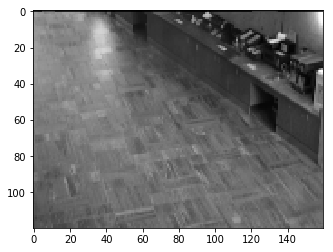

In [427]:
F_rec = X_rec

def get_image(M, j):
    img = M[:, j].reshape(120, 160)
    img = img / img.max() * 255
    img = img.astype(np.uint8)
    
    return img

plt.imshow(get_image(F_rec, 19), cmap='gray')

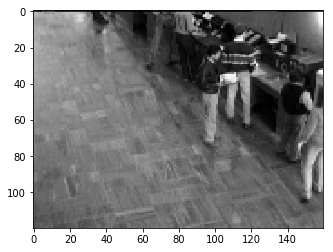

In [428]:
plt.imshow(get_image(F, 19), cmap='gray')

In [429]:
print("Rank of low-rank part is", np.linalg.matrix_rank(F_rec))

Rank of low-rank part is 3


In [495]:
import os

back_dir = "./background/"
fore_dir = "./foreground/"
orig_dir = "./original/"

def save_bmps(orig_dst, back_dst, fore_dst, M, M_rec):
    assert M.shape == M_rec.shape

    for j in range(M_rec.shape[1]):
        back_j = M_rec[:, j].reshape(120, 160)
        back_j = back_j * 255 / back_j.max()
        
        orig_j = M[:, j].reshape(120, 160)
        
        fore_j = np.maximum(0, orig_j - back_j)

        back_j = Image.fromarray(back_j.astype(np.uint8))
        back_j.save(back_dst + 'b{0:05d}.bmp'.format(j))

        fore_j = Image.fromarray(fore_j.astype(np.uint8))
        fore_j.save(fore_dst + 'b{0:05d}.bmp'.format(j))

        orig_j = Image.fromarray(orig_j.astype(np.uint8))
        orig_j.save(orig_dst + 'b{0:05d}.bmp'.format(j))

In [496]:
os.makedirs(back_dir, exist_ok=True)
os.makedirs(fore_dir, exist_ok=True)
os.makedirs(orig_dir, exist_ok=True)
save_bmps(orig_dir, back_dir, fore_dir, F, F_rec)

In [497]:
%%bash

function make_video {
    ffmpeg -framerate 60 -i $1/b0%04d.bmp -r 60 -y $1.mp4
}

for dir in Bootstrap original background foreground; do
    make_video $dir
done

ffmpeg version 4.0.3 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 8 (GCC)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --docdir=/usr/share/doc/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -g -pipe -Wall -Werror=format-security -Wp,-D_FORTIFY_SOURCE=2 -Wp,-D_GLIBCXX_ASSERTIONS -fexceptions -fstack-protector-strong -grecord-gcc-switches -specs=/usr/lib/rpm/redhat/redhat-hardened-cc1 -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -m64 -mtune=generic -fasynchronous-unwind-tables -fstack-clash-protection -fcf-protection' --extra-ldflags='-Wl,-z,relro -Wl,-z,now -specs=/usr/lib/rpm/redhat/redhat-hardened-ld ' --extra-cflags=' ' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --disable-crystalhd --enable-fontconfig --enable-frei0r --enable-gcrypt --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-